In [1]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from matplotlib import pylab as plt

import optuna

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
from my_oanda.my_oanda import Bot

In [4]:
class MyBot(Bot):
    def set_param(self, a, b, c, d, stop_loss, take_profit):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.params = {"a":a, "b":b, "c":c, "d":d, "stop_loss":stop_loss, "take_profit":take_profit}
        
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=self.a)
        ema = self.ema(period=self.b)
        atr = self.atr(period=self.c)
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < self.d )& (self.df.C < lower)
        self.sell_entry = (rsi > 100-self.d) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C


In [5]:
start = "2020-1-1"
end = "2020-12-31"
glan = "M5"
inst = "USD_JPY"

In [6]:
mybot = MyBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
    folder = "../data/"
)

In [7]:
df_list = []

def objective(trial):
    a = trial.suggest_int('a', 5, 50)
    b = trial.suggest_int('b', 5, 50)
    c = trial.suggest_int('c', 5, 50)
    d = trial.suggest_int('d', 20, 40)
    
    sl = trial.suggest_int('stop_loss', 5, 50)
    tp = trial.suggest_int('take_profit', 5, 50)
    
    mybot.set_param(a, b, c, d, sl, tp)
    
    df =  mybot.backtest(from_date=start, to_date=end)
    df.loc['a'] = a
    df.loc['b'] = b
    df.loc['c'] = c
    df.loc['d'] = d
    df.loc['stop_loss'] = sl
    df.loc['take_profit'] = tp
    
    df_list.append(df)
    
    score = -df['total profit']
    #     print('a: %d, b: %d, score: %1.2f' % (a, b, -score))
    return score

In [8]:
df_list = []
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2021-04-03 16:00:32,681] A new study created in memory with name: no-name-470b9a5c-dd19-4ddf-9505-2f5e7ad157d3
[I 2021-04-03 16:00:52,248] Trial 0 finished with value: -104590.0 and parameters: {'a': 24, 'b': 34, 'c': 12, 'd': 27, 'stop_loss': 9, 'take_profit': 47}. Best is trial 0 with value: -104590.0.
[I 2021-04-03 16:00:52,604] Trial 1 finished with value: -55500.0 and parameters: {'a': 29, 'b': 40, 'c': 11, 'd': 27, 'stop_loss': 7, 'take_profit': 27}. Best is trial 0 with value: -104590.0.
[I 2021-04-03 16:00:52,952] Trial 2 finished with value: -6220.0 and parameters: {'a': 28, 'b': 44, 'c': 16, 'd': 22, 'stop_loss': 29, 'take_profit': 23}. Best is trial 0 with value: -104590.0.
[I 2021-04-03 16:00:53,343] Trial 3 finished with value: -44440.0 and parameters: {'a': 31, 'b': 30, 'c': 5, 'd': 35, 'stop_loss': 28, 'take_profit': 26}. Best is trial 0 with value: -104590.0.
[I 2021-04-03 16:00:53,752] Trial 4 finished with value: -75070.0 and parameters: {'a': 40, 'b': 16, 'c': 27,

[I 2021-04-03 16:01:08,787] Trial 39 finished with value: -102720.0 and parameters: {'a': 14, 'b': 18, 'c': 42, 'd': 36, 'stop_loss': 33, 'take_profit': 25}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:09,230] Trial 40 finished with value: -82140.0 and parameters: {'a': 10, 'b': 32, 'c': 19, 'd': 26, 'stop_loss': 17, 'take_profit': 16}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:09,750] Trial 41 finished with value: -163190.0 and parameters: {'a': 5, 'b': 27, 'c': 17, 'd': 32, 'stop_loss': 5, 'take_profit': 28}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:10,213] Trial 42 finished with value: -106430.0 and parameters: {'a': 7, 'b': 25, 'c': 9, 'd': 34, 'stop_loss': 7, 'take_profit': 27}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:10,676] Trial 43 finished with value: -119040.0 and parameters: {'a': 11, 'b': 28, 'c': 29, 'd': 31, 'stop_loss': 8, 'take_profit': 34}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:

[I 2021-04-03 16:01:27,020] Trial 79 finished with value: -125890.0 and parameters: {'a': 6, 'b': 5, 'c': 12, 'd': 35, 'stop_loss': 7, 'take_profit': 26}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:27,430] Trial 80 finished with value: -161090.0 and parameters: {'a': 7, 'b': 8, 'c': 6, 'd': 37, 'stop_loss': 46, 'take_profit': 20}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:27,937] Trial 81 finished with value: -215750.0 and parameters: {'a': 6, 'b': 14, 'c': 13, 'd': 34, 'stop_loss': 5, 'take_profit': 25}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:28,449] Trial 82 finished with value: -218440.0 and parameters: {'a': 6, 'b': 14, 'c': 10, 'd': 34, 'stop_loss': 5, 'take_profit': 25}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:28,955] Trial 83 finished with value: -227690.0 and parameters: {'a': 5, 'b': 11, 'c': 10, 'd': 34, 'stop_loss': 5, 'take_profit': 25}. Best is trial 22 with value: -235810.0.
[I 2021-04-03 16:01:29

[I 2021-04-03 16:01:46,242] Trial 119 finished with value: -188660.0 and parameters: {'a': 11, 'b': 49, 'c': 11, 'd': 39, 'stop_loss': 8, 'take_profit': 45}. Best is trial 109 with value: -237920.0.
[I 2021-04-03 16:01:46,722] Trial 120 finished with value: -176190.0 and parameters: {'a': 9, 'b': 12, 'c': 5, 'd': 37, 'stop_loss': 9, 'take_profit': 50}. Best is trial 109 with value: -237920.0.
[I 2021-04-03 16:01:47,210] Trial 121 finished with value: -204920.0 and parameters: {'a': 10, 'b': 13, 'c': 7, 'd': 37, 'stop_loss': 6, 'take_profit': 48}. Best is trial 109 with value: -237920.0.
[I 2021-04-03 16:01:47,729] Trial 122 finished with value: -227400.0 and parameters: {'a': 8, 'b': 16, 'c': 9, 'd': 40, 'stop_loss': 5, 'take_profit': 46}. Best is trial 109 with value: -237920.0.
[I 2021-04-03 16:01:48,241] Trial 123 finished with value: -176780.0 and parameters: {'a': 8, 'b': 16, 'c': 9, 'd': 40, 'stop_loss': 6, 'take_profit': 44}. Best is trial 109 with value: -237920.0.
[I 2021-04-0

[I 2021-04-03 16:02:05,262] Trial 158 finished with value: -165800.0 and parameters: {'a': 12, 'b': 19, 'c': 8, 'd': 40, 'stop_loss': 8, 'take_profit': 45}. Best is trial 135 with value: -239780.0.
[I 2021-04-03 16:02:05,780] Trial 159 finished with value: -222630.0 and parameters: {'a': 10, 'b': 20, 'c': 6, 'd': 39, 'stop_loss': 5, 'take_profit': 48}. Best is trial 135 with value: -239780.0.
[I 2021-04-03 16:02:06,275] Trial 160 finished with value: -198480.0 and parameters: {'a': 13, 'b': 18, 'c': 38, 'd': 40, 'stop_loss': 6, 'take_profit': 46}. Best is trial 135 with value: -239780.0.
[I 2021-04-03 16:02:06,788] Trial 161 finished with value: -227310.0 and parameters: {'a': 11, 'b': 17, 'c': 9, 'd': 39, 'stop_loss': 5, 'take_profit': 49}. Best is trial 135 with value: -239780.0.
[I 2021-04-03 16:02:07,257] Trial 162 finished with value: -241830.0 and parameters: {'a': 11, 'b': 16, 'c': 7, 'd': 38, 'stop_loss': 5, 'take_profit': 48}. Best is trial 162 with value: -241830.0.
[I 2021-0

[I 2021-04-03 16:02:24,227] Trial 197 finished with value: -232940.0 and parameters: {'a': 12, 'b': 15, 'c': 6, 'd': 38, 'stop_loss': 5, 'take_profit': 43}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:24,695] Trial 198 finished with value: -171300.0 and parameters: {'a': 16, 'b': 15, 'c': 6, 'd': 38, 'stop_loss': 8, 'take_profit': 46}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:25,140] Trial 199 finished with value: -216300.0 and parameters: {'a': 12, 'b': 14, 'c': 5, 'd': 37, 'stop_loss': 6, 'take_profit': 43}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:25,632] Trial 200 finished with value: -216340.0 and parameters: {'a': 13, 'b': 15, 'c': 6, 'd': 38, 'stop_loss': 5, 'take_profit': 45}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:26,112] Trial 201 finished with value: -237430.0 and parameters: {'a': 14, 'b': 12, 'c': 8, 'd': 38, 'stop_loss': 5, 'take_profit': 49}. Best is trial 174 with value: -249150.0.
[I 2021-04

[I 2021-04-03 16:02:42,619] Trial 236 finished with value: -221720.0 and parameters: {'a': 13, 'b': 14, 'c': 7, 'd': 38, 'stop_loss': 5, 'take_profit': 45}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:43,084] Trial 237 finished with value: -181650.0 and parameters: {'a': 12, 'b': 17, 'c': 6, 'd': 40, 'stop_loss': 6, 'take_profit': 50}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:43,571] Trial 238 finished with value: -221230.0 and parameters: {'a': 16, 'b': 16, 'c': 8, 'd': 39, 'stop_loss': 5, 'take_profit': 48}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:44,054] Trial 239 finished with value: -206890.0 and parameters: {'a': 11, 'b': 12, 'c': 5, 'd': 38, 'stop_loss': 7, 'take_profit': 46}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:02:44,545] Trial 240 finished with value: -173410.0 and parameters: {'a': 15, 'b': 15, 'c': 7, 'd': 40, 'stop_loss': 6, 'take_profit': 47}. Best is trial 174 with value: -249150.0.
[I 2021-04

[I 2021-04-03 16:03:01,640] Trial 275 finished with value: -230210.0 and parameters: {'a': 13, 'b': 13, 'c': 6, 'd': 40, 'stop_loss': 6, 'take_profit': 48}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:03:02,123] Trial 276 finished with value: -199170.0 and parameters: {'a': 11, 'b': 14, 'c': 8, 'd': 38, 'stop_loss': 8, 'take_profit': 46}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:03:02,582] Trial 277 finished with value: -112570.0 and parameters: {'a': 14, 'b': 15, 'c': 10, 'd': 39, 'stop_loss': 21, 'take_profit': 49}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:03:03,086] Trial 278 finished with value: -175010.0 and parameters: {'a': 12, 'b': 16, 'c': 7, 'd': 40, 'stop_loss': 6, 'take_profit': 50}. Best is trial 174 with value: -249150.0.
[I 2021-04-03 16:03:03,522] Trial 279 finished with value: -140810.0 and parameters: {'a': 28, 'b': 15, 'c': 9, 'd': 37, 'stop_loss': 5, 'take_profit': 47}. Best is trial 174 with value: -249150.0.
[I 2021-

[I 2021-04-03 16:03:20,306] Trial 314 finished with value: -205130.0 and parameters: {'a': 9, 'b': 13, 'c': 32, 'd': 40, 'stop_loss': 6, 'take_profit': 48}. Best is trial 303 with value: -258170.0.
[I 2021-04-03 16:03:20,807] Trial 315 finished with value: -226840.0 and parameters: {'a': 11, 'b': 12, 'c': 43, 'd': 40, 'stop_loss': 5, 'take_profit': 50}. Best is trial 303 with value: -258170.0.
[I 2021-04-03 16:03:21,282] Trial 316 finished with value: -181440.0 and parameters: {'a': 17, 'b': 13, 'c': 8, 'd': 40, 'stop_loss': 7, 'take_profit': 47}. Best is trial 303 with value: -258170.0.
[I 2021-04-03 16:03:21,776] Trial 317 finished with value: -211770.0 and parameters: {'a': 12, 'b': 13, 'c': 12, 'd': 39, 'stop_loss': 6, 'take_profit': 49}. Best is trial 303 with value: -258170.0.
[I 2021-04-03 16:03:22,279] Trial 318 finished with value: -223300.0 and parameters: {'a': 16, 'b': 16, 'c': 9, 'd': 40, 'stop_loss': 5, 'take_profit': 50}. Best is trial 303 with value: -258170.0.
[I 2021-

[I 2021-04-03 16:03:38,817] Trial 353 finished with value: -251070.0 and parameters: {'a': 6, 'b': 7, 'c': 10, 'd': 38, 'stop_loss': 6, 'take_profit': 45}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:39,271] Trial 354 finished with value: -210510.0 and parameters: {'a': 6, 'b': 6, 'c': 12, 'd': 38, 'stop_loss': 6, 'take_profit': 45}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:39,726] Trial 355 finished with value: -222920.0 and parameters: {'a': 6, 'b': 6, 'c': 10, 'd': 37, 'stop_loss': 5, 'take_profit': 43}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:40,157] Trial 356 finished with value: -259810.0 and parameters: {'a': 7, 'b': 7, 'c': 9, 'd': 38, 'stop_loss': 6, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:40,632] Trial 357 finished with value: -225360.0 and parameters: {'a': 5, 'b': 8, 'c': 10, 'd': 38, 'stop_loss': 8, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16

[I 2021-04-03 16:03:57,597] Trial 393 finished with value: -236600.0 and parameters: {'a': 8, 'b': 7, 'c': 11, 'd': 37, 'stop_loss': 5, 'take_profit': 46}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:58,047] Trial 394 finished with value: -219670.0 and parameters: {'a': 6, 'b': 9, 'c': 13, 'd': 36, 'stop_loss': 6, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:58,521] Trial 395 finished with value: -232700.0 and parameters: {'a': 9, 'b': 10, 'c': 12, 'd': 37, 'stop_loss': 8, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:59,008] Trial 396 finished with value: -249170.0 and parameters: {'a': 7, 'b': 8, 'c': 10, 'd': 37, 'stop_loss': 5, 'take_profit': 46}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:03:59,498] Trial 397 finished with value: -242160.0 and parameters: {'a': 5, 'b': 8, 'c': 11, 'd': 36, 'stop_loss': 5, 'take_profit': 46}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 

[I 2021-04-03 16:04:15,883] Trial 432 finished with value: -226080.0 and parameters: {'a': 8, 'b': 7, 'c': 12, 'd': 38, 'stop_loss': 5, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:16,367] Trial 433 finished with value: -255550.0 and parameters: {'a': 9, 'b': 9, 'c': 9, 'd': 38, 'stop_loss': 6, 'take_profit': 33}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:16,844] Trial 434 finished with value: -197620.0 and parameters: {'a': 10, 'b': 9, 'c': 9, 'd': 38, 'stop_loss': 7, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:17,312] Trial 435 finished with value: -227770.0 and parameters: {'a': 9, 'b': 8, 'c': 9, 'd': 37, 'stop_loss': 8, 'take_profit': 31}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:17,794] Trial 436 finished with value: -184700.0 and parameters: {'a': 7, 'b': 10, 'c': 11, 'd': 38, 'stop_loss': 10, 'take_profit': 33}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 1

[I 2021-04-03 16:04:34,232] Trial 471 finished with value: -257710.0 and parameters: {'a': 8, 'b': 9, 'c': 9, 'd': 38, 'stop_loss': 5, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:34,717] Trial 472 finished with value: -218250.0 and parameters: {'a': 8, 'b': 9, 'c': 9, 'd': 37, 'stop_loss': 8, 'take_profit': 42}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:35,133] Trial 473 finished with value: -105270.0 and parameters: {'a': 37, 'b': 9, 'c': 10, 'd': 38, 'stop_loss': 5, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:35,605] Trial 474 finished with value: -232330.0 and parameters: {'a': 7, 'b': 7, 'c': 8, 'd': 39, 'stop_loss': 7, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:36,122] Trial 475 finished with value: -240540.0 and parameters: {'a': 6, 'b': 10, 'c': 8, 'd': 37, 'stop_loss': 5, 'take_profit': 43}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:

[I 2021-04-03 16:04:53,228] Trial 511 finished with value: -248640.0 and parameters: {'a': 9, 'b': 8, 'c': 7, 'd': 38, 'stop_loss': 8, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:53,763] Trial 512 finished with value: -193640.0 and parameters: {'a': 7, 'b': 47, 'c': 9, 'd': 39, 'stop_loss': 5, 'take_profit': 39}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:54,224] Trial 513 finished with value: -192770.0 and parameters: {'a': 6, 'b': 6, 'c': 9, 'd': 38, 'stop_loss': 7, 'take_profit': 38}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:54,695] Trial 514 finished with value: -237400.0 and parameters: {'a': 7, 'b': 10, 'c': 8, 'd': 38, 'stop_loss': 5, 'take_profit': 42}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:04:55,162] Trial 515 finished with value: -156510.0 and parameters: {'a': 8, 'b': 8, 'c': 9, 'd': 39, 'stop_loss': 15, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:

[I 2021-04-03 16:05:12,343] Trial 551 finished with value: -238440.0 and parameters: {'a': 9, 'b': 10, 'c': 8, 'd': 39, 'stop_loss': 6, 'take_profit': 46}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:12,863] Trial 552 finished with value: -249770.0 and parameters: {'a': 8, 'b': 12, 'c': 8, 'd': 39, 'stop_loss': 5, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:13,370] Trial 553 finished with value: -146300.0 and parameters: {'a': 6, 'b': 42, 'c': 7, 'd': 39, 'stop_loss': 8, 'take_profit': 46}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:13,884] Trial 554 finished with value: -250670.0 and parameters: {'a': 8, 'b': 10, 'c': 8, 'd': 39, 'stop_loss': 5, 'take_profit': 47}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:14,387] Trial 555 finished with value: -246940.0 and parameters: {'a': 7, 'b': 9, 'c': 7, 'd': 38, 'stop_loss': 6, 'take_profit': 32}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16

[I 2021-04-03 16:05:30,967] Trial 591 finished with value: -210080.0 and parameters: {'a': 7, 'b': 6, 'c': 7, 'd': 39, 'stop_loss': 6, 'take_profit': 47}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:31,449] Trial 592 finished with value: -261830.0 and parameters: {'a': 6, 'b': 7, 'c': 8, 'd': 39, 'stop_loss': 6, 'take_profit': 46}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:31,884] Trial 593 finished with value: -155510.0 and parameters: {'a': 21, 'b': 7, 'c': 9, 'd': 39, 'stop_loss': 9, 'take_profit': 30}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:32,316] Trial 594 finished with value: -128610.0 and parameters: {'a': 5, 'b': 5, 'c': 8, 'd': 40, 'stop_loss': 7, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:32,731] Trial 595 finished with value: -194180.0 and parameters: {'a': 5, 'b': 6, 'c': 9, 'd': 38, 'stop_loss': 7, 'take_profit': 45}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05

[I 2021-04-03 16:05:49,876] Trial 631 finished with value: -259300.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 35, 'stop_loss': 5, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:50,377] Trial 632 finished with value: -257620.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 35, 'stop_loss': 5, 'take_profit': 39}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:50,802] Trial 633 finished with value: -180810.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 35, 'stop_loss': 26, 'take_profit': 39}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:51,298] Trial 634 finished with value: -262330.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 36, 'stop_loss': 5, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05:51,799] Trial 635 finished with value: -258860.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 35, 'stop_loss': 5, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:05

[I 2021-04-03 16:06:09,039] Trial 671 finished with value: -222860.0 and parameters: {'a': 5, 'b': 7, 'c': 6, 'd': 36, 'stop_loss': 7, 'take_profit': 39}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:09,519] Trial 672 finished with value: -240750.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 35, 'stop_loss': 8, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:09,974] Trial 673 finished with value: -203560.0 and parameters: {'a': 6, 'b': 6, 'c': 6, 'd': 36, 'stop_loss': 6, 'take_profit': 37}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:10,474] Trial 674 finished with value: -197910.0 and parameters: {'a': 5, 'b': 9, 'c': 18, 'd': 36, 'stop_loss': 7, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:10,967] Trial 675 finished with value: -254840.0 and parameters: {'a': 6, 'b': 8, 'c': 6, 'd': 36, 'stop_loss': 6, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06

[I 2021-04-03 16:06:28,284] Trial 711 finished with value: -240740.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 36, 'stop_loss': 8, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:28,804] Trial 712 finished with value: -258690.0 and parameters: {'a': 6, 'b': 9, 'c': 6, 'd': 35, 'stop_loss': 5, 'take_profit': 38}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:29,308] Trial 713 finished with value: -256950.0 and parameters: {'a': 5, 'b': 7, 'c': 5, 'd': 36, 'stop_loss': 6, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:29,855] Trial 714 finished with value: -225570.0 and parameters: {'a': 5, 'b': 10, 'c': 6, 'd': 35, 'stop_loss': 7, 'take_profit': 42}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:30,250] Trial 715 finished with value: -108770.0 and parameters: {'a': 6, 'b': 5, 'c': 5, 'd': 36, 'stop_loss': 10, 'take_profit': 39}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:0

[I 2021-04-03 16:06:48,174] Trial 751 finished with value: -245650.0 and parameters: {'a': 6, 'b': 8, 'c': 7, 'd': 37, 'stop_loss': 6, 'take_profit': 42}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:48,664] Trial 752 finished with value: -227510.0 and parameters: {'a': 5, 'b': 9, 'c': 7, 'd': 36, 'stop_loss': 10, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:49,175] Trial 753 finished with value: -220490.0 and parameters: {'a': 6, 'b': 10, 'c': 5, 'd': 36, 'stop_loss': 6, 'take_profit': 17}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:49,668] Trial 754 finished with value: -241160.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 35, 'stop_loss': 7, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:06:50,087] Trial 755 finished with value: -207470.0 and parameters: {'a': 7, 'b': 6, 'c': 6, 'd': 37, 'stop_loss': 5, 'take_profit': 39}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:0

[I 2021-04-03 16:07:07,469] Trial 791 finished with value: -238750.0 and parameters: {'a': 7, 'b': 8, 'c': 6, 'd': 35, 'stop_loss': 7, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:07,989] Trial 792 finished with value: -266810.0 and parameters: {'a': 5, 'b': 9, 'c': 6, 'd': 37, 'stop_loss': 6, 'take_profit': 35}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:08,505] Trial 793 finished with value: -226960.0 and parameters: {'a': 5, 'b': 10, 'c': 5, 'd': 37, 'stop_loss': 8, 'take_profit': 35}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:08,988] Trial 794 finished with value: -254490.0 and parameters: {'a': 5, 'b': 9, 'c': 5, 'd': 37, 'stop_loss': 5, 'take_profit': 35}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:09,512] Trial 795 finished with value: -240970.0 and parameters: {'a': 5, 'b': 9, 'c': 6, 'd': 36, 'stop_loss': 7, 'take_profit': 37}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07

[I 2021-04-03 16:07:27,690] Trial 831 finished with value: -219480.0 and parameters: {'a': 5, 'b': 8, 'c': 5, 'd': 36, 'stop_loss': 9, 'take_profit': 36}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:28,221] Trial 832 finished with value: -209540.0 and parameters: {'a': 5, 'b': 9, 'c': 20, 'd': 37, 'stop_loss': 6, 'take_profit': 37}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:28,683] Trial 833 finished with value: -196830.0 and parameters: {'a': 5, 'b': 10, 'c': 5, 'd': 36, 'stop_loss': 9, 'take_profit': 38}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:29,214] Trial 834 finished with value: -155690.0 and parameters: {'a': 5, 'b': 32, 'c': 27, 'd': 37, 'stop_loss': 6, 'take_profit': 38}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:29,706] Trial 835 finished with value: -234830.0 and parameters: {'a': 5, 'b': 8, 'c': 6, 'd': 36, 'stop_loss': 7, 'take_profit': 35}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16

[I 2021-04-03 16:07:47,360] Trial 871 finished with value: -260110.0 and parameters: {'a': 5, 'b': 8, 'c': 6, 'd': 36, 'stop_loss': 5, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:47,742] Trial 872 finished with value: -111170.0 and parameters: {'a': 26, 'b': 9, 'c': 42, 'd': 35, 'stop_loss': 7, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:48,220] Trial 873 finished with value: -198100.0 and parameters: {'a': 6, 'b': 6, 'c': 5, 'd': 37, 'stop_loss': 6, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:48,685] Trial 874 finished with value: -253200.0 and parameters: {'a': 7, 'b': 7, 'c': 7, 'd': 31, 'stop_loss': 8, 'take_profit': 43}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:07:49,209] Trial 875 finished with value: -251210.0 and parameters: {'a': 5, 'b': 10, 'c': 5, 'd': 36, 'stop_loss': 5, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:

[I 2021-04-03 16:08:06,848] Trial 911 finished with value: -64320.0 and parameters: {'a': 44, 'b': 9, 'c': 6, 'd': 35, 'stop_loss': 5, 'take_profit': 38}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:07,282] Trial 912 finished with value: -230450.0 and parameters: {'a': 5, 'b': 7, 'c': 5, 'd': 36, 'stop_loss': 7, 'take_profit': 43}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:07,794] Trial 913 finished with value: -266850.0 and parameters: {'a': 7, 'b': 9, 'c': 7, 'd': 37, 'stop_loss': 5, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:08,308] Trial 914 finished with value: -226470.0 and parameters: {'a': 8, 'b': 11, 'c': 8, 'd': 37, 'stop_loss': 6, 'take_profit': 42}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:08,827] Trial 915 finished with value: -247330.0 and parameters: {'a': 8, 'b': 10, 'c': 8, 'd': 37, 'stop_loss': 5, 'take_profit': 43}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:0

[I 2021-04-03 16:08:26,735] Trial 951 finished with value: -176020.0 and parameters: {'a': 6, 'b': 9, 'c': 50, 'd': 37, 'stop_loss': 6, 'take_profit': 43}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:27,220] Trial 952 finished with value: -216220.0 and parameters: {'a': 6, 'b': 8, 'c': 6, 'd': 37, 'stop_loss': 9, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:27,741] Trial 953 finished with value: -220580.0 and parameters: {'a': 8, 'b': 11, 'c': 5, 'd': 36, 'stop_loss': 5, 'take_profit': 40}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:28,236] Trial 954 finished with value: -197820.0 and parameters: {'a': 10, 'b': 9, 'c': 8, 'd': 38, 'stop_loss': 7, 'take_profit': 37}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:28,769] Trial 955 finished with value: -108650.0 and parameters: {'a': 6, 'b': 24, 'c': 6, 'd': 36, 'stop_loss': 6, 'take_profit': 42}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16

[I 2021-04-03 16:08:46,138] Trial 991 finished with value: -227980.0 and parameters: {'a': 5, 'b': 9, 'c': 5, 'd': 37, 'stop_loss': 7, 'take_profit': 42}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:46,604] Trial 992 finished with value: -213470.0 and parameters: {'a': 7, 'b': 6, 'c': 7, 'd': 38, 'stop_loss': 5, 'take_profit': 44}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:47,088] Trial 993 finished with value: -239910.0 and parameters: {'a': 5, 'b': 7, 'c': 6, 'd': 36, 'stop_loss': 6, 'take_profit': 19}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:47,579] Trial 994 finished with value: -206880.0 and parameters: {'a': 8, 'b': 9, 'c': 46, 'd': 37, 'stop_loss': 7, 'take_profit': 39}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:08:48,106] Trial 995 finished with value: -216030.0 and parameters: {'a': 6, 'b': 11, 'c': 31, 'd': 36, 'stop_loss': 5, 'take_profit': 41}. Best is trial 340 with value: -278350.0.
[I 2021-04-03 16:

In [9]:
df_all = pd.concat(df_list, axis=1).T
df_over_spread = df_all[df_all['average return'] > 40].sort_values('total profit', ascending=False)
df_over_spread

,total profit,total trades,win rate,profit factor,maximum drawdown,recovery factor,riskreward ratio,sharpe ratio,average return,stop loss,take profit,a,b,c,d,stop_loss,take_profit
780,259380.0,5697.0,60.646,1.196,15230.0,17.031,0.866,0.070,40.434,2141.0,9.0,5.0,7.0,5.0,37.0,6.0,41.0
650,256950.0,5682.0,60.612,1.194,15230.0,16.871,0.866,0.070,40.161,2137.0,9.0,5.0,7.0,5.0,36.0,6.0,41.0
713,256950.0,5682.0,60.612,1.194,15230.0,16.871,0.866,0.070,40.161,2137.0,9.0,5.0,7.0,5.0,36.0,6.0,41.0
676,255190.0,5658.0,60.622,1.194,16330.0,15.627,0.865,0.069,40.046,2129.0,11.0,5.0,7.0,5.0,35.0,6.0,40.0
925,253870.0,5594.0,60.619,1.194,16700.0,15.202,0.868,0.070,40.299,2116.0,9.0,7.0,7.0,6.0,36.0,6.0,41.0
760,253260.0,5597.0,60.425,1.193,17870.0,14.172,0.872,0.069,40.203,2128.0,13.0,6.0,7.0,7.0,32.0,6.0,39.0
874,253200.0,4948.0,63.561,1.210,19270.0,13.140,0.738,0.073,46.366,1415.0,10.0,7.0,7.0,7.0,31.0,8.0,43.0
511,248640.0,5574.0,62.594,1.175,26920.0,9.236,0.748,0.062,40.279,1675.0,17.0,9.0,8.0,7.0,38.0,8.0,40.0
619,240780.0,4821.0,60.527,1.211,15270.0,15.768,0.888,0.074,44.034,1854.0,7.0,8.0,7.0,9.0,29.0,6.0,44.0
567,238020.0,5227.0,60.187,1.193,14070.0,16.917,0.882,0.069,40.294,2004.0,8.0,10.0,7.0,6.0,38.0,6.0,43.0


In [10]:
params = dict(df_over_spread[["a","b","c","d","stop_loss", "take_profit"]].iloc[0].astype(int))

In [11]:
# params=study.best_trial.params

In [12]:
params

{'a': 5, 'b': 7, 'c': 5, 'd': 37, 'stop_loss': 6, 'take_profit': 41}

In [13]:
mybot.set_param(params['a'], params['b'], params['c'], params['d'], params['stop_loss'], params['take_profit'])

total profit        259380.000
total trades          5697.000
win rate                60.646
profit factor            1.196
maximum drawdown     15230.000
recovery factor         17.031
riskreward ratio         0.866
sharpe ratio             0.070
average return          40.434
stop loss             2141.000
take profit              9.000
dtype: float64


total profit        259380.000
total trades          5697.000
win rate                60.646
profit factor            1.196
maximum drawdown     15230.000
recovery factor         17.031
riskreward ratio         0.866
sharpe ratio             0.070
average return          40.434
stop loss             2141.000
take profit              9.000
dtype: float64

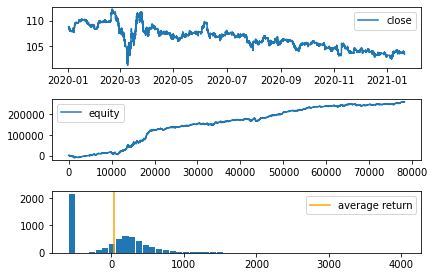

In [14]:
mybot.backtest(from_date=start, to_date=end, filename="hogebacktest.png", show=True)

total profit        15260.000
total trades          645.000
win rate               64.031
profit factor           1.139
maximum drawdown     6890.000
recovery factor         2.215
riskreward ratio        0.654
sharpe ratio            0.053
average return         22.322
stop loss             173.000
take profit             0.000
dtype: float64


total profit        15260.000
total trades          645.000
win rate               64.031
profit factor           1.139
maximum drawdown     6890.000
recovery factor         2.215
riskreward ratio        0.654
sharpe ratio            0.053
average return         22.322
stop loss             173.000
take profit             0.000
dtype: float64

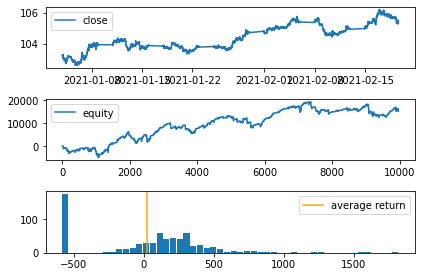

In [15]:
start_rev = "2021-1-1"
end_rev = "2021-2-19"
mybot.backtest(from_date=start_rev, to_date=end_rev, filename="hogebacktest.png", show=True)

In [16]:
#total profit        14490.000